In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [4]:
datafile = os.path.join(".","final.txt")
MAX_LENGTH = 12  # Maximum sentence length to consider
import json
with open('contractions.json', 'r') as fp:
    good_prefixes = json.load(fp)
    good_prefixes = {key.strip().lower():value.strip().lower() for key,value in good_prefixes.items()}

good_prefixes


{"ain't": 'am not',
 "amn't": 'am not',
 "aren't": 'are not',
 "can't": 'cannot',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "daren't": 'dare not',
 "daresn't": 'dare not',
 "dasn't": 'dare not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "e'er": 'ever',
 "everyone's": 'everyone is',
 'finna': 'fixing to',
 'gimme': 'give me',
 'gonna': 'going to',
 "gon't": 'go not',
 'gotta': 'got to',
 "hadn't": 'had not',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had',
 "he'll": 'he shall',
 "he's": 'he has',
 "he've": 'he have',
 "how'd": 'how did',
 "how'll": 'how will',
 "how're": 'how are',
 "how's": 'how has',
 "i'd": 'i had',
 "i'll": 'i shall',
 "i'm": 'i am',
 "i'm'a": 'i am about to',
 "i'm'o": 'i am going to',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'll": 'it shall',
 "it's": 'it has',
 "let's": 'let us',
 "mayn't": 'may not',
 "may've": 'may have',
 "mightn'

In [5]:
datafile

'./final.txt'

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = " ".join([good_prefixes[each] if each in good_prefixes else each for each in s.split()])
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
#    s = re.sub(r'\.+', " ", s)
    pattern = re.compile(r"(.)\1{2,}")
    s=  pattern.sub(r"\1\1", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split("\n")
    # Split every line into pairs and normalize
#     pairs = [[normalizeString(s) for s in l.split('<CoSe>')] for l in lines]
    human = []
    reply = []
    for line in lines:
        if line.lower().startswith('human'):
            if human != []:
                if p_v.lower().startswith('human'):
                    human[-1] = human[-1] + ". " + normalizeString(line.strip().partition(":")[2])
#                     human[-1] = human[-1] + ". " + line.strip().partition(':')[2]
                else:
                    human.append(normalizeString(line.strip().partition(':')[2]))
            else:
                human.append(normalizeString(line.strip().partition(':')[2]))
        elif line.lower().startswith('reply'):
            if reply != []:
                if p_v.lower().startswith('reply'):
                    reply[-1] = reply[-1] + ". " + normalizeString(line.strip().partition(':')[2])
                else:
                    reply.append(normalizeString(line.strip().partition(":")[2]))
            else:
                reply.append(normalizeString(line.strip().partition(':')[2]))
        else:
            reply[-1]=reply[-1]+ normalizeString(line.strip())
        p_v = line
        
    pairs = []
    for h, r in zip(human,reply):
        pairs.append([h,r])
        
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    if len(p)==2:
        return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split('  ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join(".","model", "save")
corpus_name = 'chatbot'
voc, pairs = loadPrepareData(corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print (pair)

Start preparing training data ...
Reading lines...
Read 503 sentence pairs
Trimmed to 393 sentence pairs
Counting words...
Counted words: 937

pairs:
['hello', 'hello sir mam how can we assist you ?']
['i want to know about the managed wifi .', 'managed wifiwe have come up with a feature that gives you access to the list of devices connected to your router and total bandwidth usage . furthermore with just a small upgrade you can get dual band router for better internet experience .you can also gain information about the application from the https ww .youtube .com watch ?v faxyr c jfs']
['hello', 'hello sir mam how can we assist you ?']
['i have to register for this feature ?', 'yes sir mam .']
['what kind of user are eligible for this feature ?', 'all the worldlink user are eligible for this feature .']
['how long it will take to register ?', 'it will take about one day sir .']
['okay sir', 'welcome sir mam']
['hi', 'hello sir mam how can we assist you ?']
['can you describe me about t

In [7]:
# MIN_COUNT = 3    # Minimum word count threshold for trimming

# def trimRareWords(voc, pairs, MIN_COUNT):
#     # Trim words used under the MIN_COUNT from the voc
#     voc.trim(MIN_COUNT)
#     # Filter out pairs with trimmed words
#     keep_pairs = []
#     for pair in pairs:
#         input_sentence = pair[0]
#         output_sentence = pair[1]
#         keep_input = True
#         keep_output = True
#         # Check input sentence
#         for word in input_sentence.split(' '):
#             if word not in voc.word2index:
#                 keep_input = False
#                 break
#         # Check output sentence
#         for word in output_sentence.split(' '):
#             if word not in voc.word2index:
#                 keep_output = False
#                 break

#         # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
#         if keep_input and keep_output:
#             keep_pairs.append(pair)

#     print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
#     return keep_pairs


# # Trim voc and pairs
# pairs = trimRareWords(voc, pairs, MIN_COUNT)

In [8]:
# with open(os.path.join(".","pickles","vocab.file"), "wb") as f:
#     pickle.dump(voc, f, pickle.HIGHEST_PROTOCOL)

In [9]:
# with open(os.path.join(".","pickles","vocab.file"), "rb") as f:
#     dump = pickle.load(f)
# print(dir(dump))

In [10]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
# batches = batch2TrainData(voc,[for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[423,   7,  73, 698,  85],
        [ 10,  10,  10,   4,   2],
        [147, 675, 763,  20,   0],
        [570,  87,  11,   2,   0],
        [ 17,  14,   2,   0,   0],
        [729, 463,   0,   0,   0],
        [572, 154,   0,   0,   0],
        [ 32, 695,   0,   0,   0],
        [ 17,  20,   0,   0,   0],
        [446,   2,   0,   0,   0],
        [ 20,   0,   0,   0,   0],
        [  2,   0,   0,   0,   0]])
lengths: tensor([12, 10,  5,  4,  2])
target_variable: tensor([[469, 167, 577, 698,   3],
        [  4,  10,   4,   4,   4],
        [730, 179,   5,  20,   5],
        [731,  76,   2,   6,   6],
        [317, 164,   0,   7,   7],
        [732,  97,   0,   8,   8],
        [312,  20,   0,   9,   9],
        [ 14,   2,   0,  10,  10],
        [733,   0,   0,  11,  11],
        [734,   0,   0,   2,   2],
        [ 14,   0,   0,   0,   0],
        [735,   0,   0,   0,   0],
        [312,   0,   0,   0,   0],
        [ 14,   0,   0,   0,   0],
        [733,   0,

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
#         print ("-------------------------")
#         print ("encoder forward running")
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
#         print ("encoder embeded: ", embedded)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
#         print ("encoder packed: ", packed)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
#         print ("encoder outputs: ", outputs)
#         print ("encoder hidden: ", hidden)
        # Return output and final hidden state
        return outputs, hidden

In [12]:
# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
#             print ("general: ", self.method)
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
#             print ("concat: ", self.method)
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
#         print ("dot_score running")
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
#         print ("general_score running")
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
#         print ("concat_score running")
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
#         print ("forward running")
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [13]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
#         print ("decoder forward running")
        embedded = self.embedding(input_step)
#         print ("decoder embedded: ", embedded)
        embedded = self.embedding_dropout(embedded)
#         print ("decoder embedded: ", embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
#         print ("decoder output: ", output)
#         print ("decoder hidden: ", hidden)
        # Return output and final hidden state
        return output, hidden

In [14]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [15]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [16]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]
    
    print ("Training Batch: ", len(training_batches))

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            train_loss.append(print_loss_avg)
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [17]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 512
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
train_loss=[]

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
#checkpoint_iter = 200000
#loadFilename = os.path.join(save_dir, model_name, corpus_name, 
#                           '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size), 
#                             '{}_checkpoint.tar'.format(checkpoint_iter))

# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [18]:
len(voc.word2index)

934

Run Training
~~~~~~~~~~~~

Run the following block if you want to train the model.

First we set training parameters, then we initialize our optimizers, and
finally we call the ``trainIters`` function to run our training
iterations.




In [19]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 500
print_every = 10
save_every = 25

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Training Batch:  500
Initializing ...
Training...
Iteration: 10; Percent complete: 2.0%; Average loss: 6.4213
Iteration: 20; Percent complete: 4.0%; Average loss: 5.5786
Iteration: 30; Percent complete: 6.0%; Average loss: 5.1490
Iteration: 40; Percent complete: 8.0%; Average loss: 4.9550
Iteration: 50; Percent complete: 10.0%; Average loss: 4.4951
Iteration: 60; Percent complete: 12.0%; Average loss: 4.0658
Iteration: 70; Percent complete: 14.0%; Average loss: 3.4799
Iteration: 80; Percent complete: 16.0%; Average loss: 3.1498
Iteration: 90; Percent complete: 18.0%; Average loss: 2.6992
Iteration: 100; Percent complete: 20.0%; Average loss: 2.6337
Iteration: 110; Percent complete: 22.0%; Average loss: 2.4290
Iteration: 120; Percent complete: 24.0%; Average loss: 2.1508
Iteration: 130; Percent complete: 26.0%; Average loss: 1.7530
Iteration: 140; Percent complete: 28.0%; Average loss: 1.7772
Iteration: 150; Percent complete: 30.0%; Average los

In [20]:
import matplotlib.pyplot as plt

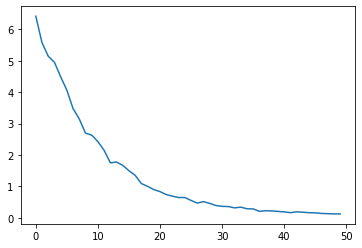

In [21]:
plt.plot(train_loss)
plt.show()

Run Evaluation
~~~~~~~~~~~~~~

To chat with your model, run the following block.




In [22]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        if not USE_MULTINOMIAL:
            for _ in range(max_length):
                # Forward pass through decoder
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                # Obtain most likely word token and its softmax score
                decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
                # Record token and score
                all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
                all_scores = torch.cat((all_scores, decoder_scores), dim=0)
                # Prepare current token to be next decoder input (add a dimension)
                decoder_input = torch.unsqueeze(decoder_input, 0)
            # Return collections of word tokens and scores
            return all_tokens, all_scores
        else:
            for _ in range(max_length):
                # Forward pass through decoder
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                
                # Sample from the network as a multinomial distribution
                decoder_output_multi = decoder_output.data.view(-1).div(TEMP).exp()
                decoder_input = torch.multinomial(decoder_output_multi, 1)
                decoder_scores,_ = torch.max(decoder_output, dim=1)
                # Record token and score
                all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
                all_scores = torch.cat((all_scores, decoder_scores), dim=0)
                # Prepare current token to be next decoder input (add a dimension)
                decoder_input = torch.unsqueeze(decoder_input, 0)
            # Return collections of word tokens and scores
            return all_tokens, all_scores
            

In [23]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH, temperature = False):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [ ]:
USE_MULTINOMIAL = False
TEMP = 0.7

# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

> hi
Bot: namastae sir mam . how can we help you ? the
> Namastae
Bot: namastae sir mam . how can we help you ? the
> My internet is not wokring?
Error: Encountered unknown word.
> my internet is not working?
Bot: please mention your query . the channels are not available you
> hello
Bot: hello sir mam how can we assist you ? channels
> fu
Error: Encountered unknown word.
> tero tauko
Bot: if you continue using such offensive and vulgar words to seek our
> Hey i am using the internet.
Bot: please elaborate your query sir . the channels are not available
> 
Bot: hello sir mam how can we assist you ? channels
> i want the new connection
Bot: we have got sir mam . you can contact our phone
> Could you please send me the detail of new connection?
Bot: if you continue using such offensive and vulgar words to seek our
> hi
Bot: namastae sir mam . how can we help you ? the
> thank you
Bot: welcome sir mam . please mention your query sir .
> kada
Error: Encountered unknown word.
> how are you
